<a href="https://www.kaggle.com/code/kelixirr/tensorflow-simplified-guide-part-2?scriptVersionId=137242162" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Graphs - tf.function

Graphs are data structures that contain a set of tf.Operation objects, which represent units of computation; and tf.Tensor objects, which represent the units of data that flow between operations. They are defined in a tf.Graph context. Since these graphs are data structures, they can be saved, run, and restored all without the original Python code. You can use your TensorFlow graph in environments that don't have a Python interpreter, like mobile applications, embedded devices, and backend servers. TensorFlow uses graphs as the format for saved models when it exports them from Python. In short, graphs are extremely useful and let your TensorFlow run fast, run in parallel, and run efficiently on multiple devices.

In [1]:
import tensorflow as tf
import timeit
from datetime import datetime
import warnings
print("Tensorflow Version", tf.__version__)
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Tensorflow Version 2.12.0


In [2]:
# Define a Python function.
def a_regular_function(x, y, b):
    x = tf.matmul(x, y)
    x = x + b
    return x

# `a_function_that_uses_a_graph` is a TensorFlow `Function`.
a_function_that_uses_a_graph = tf.function(a_regular_function)

# Make some tensors.
x1 = tf.constant([[1.0, 2.0]])
y1 = tf.constant([[2.0], [3.0]])
b1 = tf.constant(4.0)

orig_value = a_regular_function(x1, y1, b1).numpy()
# Call a `Function` like a Python function.
tf_function_value = a_function_that_uses_a_graph(x1, y1, b1).numpy()
print(orig_value)
print(tf_function_value)
assert(orig_value == tf_function_value)

[[12.]]
[[12.]]


On the outside, a Function looks like a regular function you write using TensorFlow operations. Underneath, however, it is very different. A Function encapsulates several `tf.Graphs` behind one API. That is how a Function is able to give you the benefits of graph execution, like speed and deployability. 

In [3]:
def inner_function(x, y, b):
    x = tf.matmul(x, y)
    x = x + b 
    return x 

# use decorator to make outer_function a function 
@tf.function
def outer_function(x):
    y = tf.constant([[2.0], [3.0]])
    b = tf.constant(4.0)
    return inner_function(x, y, b)

# Note that the callable will create a graph that
# includes `inner_function` as well as `outer_function`.
outer_function(tf.constant([[1.0, 2.0]])).numpy()

array([[12.]], dtype=float32)

Difference between the Normal and Graph execution 

In [4]:
x = tf.random.uniform(shape=[10, 10], minval=-1, maxval=2, dtype=tf.dtypes.int32)

def power(x, y):
    result = tf.eye(10, dtype=tf.dtypes.int32)
    for _ in range(y):
        result = tf.matmul(x, result)
    return result

In [5]:
print("Eager execution:", timeit.timeit(lambda: power(x, 100), number=1000), "seconds")

Eager execution: 6.103276827000002 seconds


In [6]:
power_as_graph = tf.function(power)
print("Graph execution:", timeit.timeit(lambda: power_as_graph(x, 100), number=1000), "seconds")

Graph execution: 1.0737274150000076 seconds


Graphs can speed up your code, but the process of creating them has some overhead. For some functions, the creation of the graph takes more time than the execution of the graph. This investment is usually quickly paid back with the performance boost of subsequent executions, but it's important to be aware that the first few steps of any large model training can be slower due to tracing.

No matter how large your model, you want to avoid tracing frequently. The tf.function guide discusses how to set input specifications and use tensor arguments to avoid retracing in the Controlling retracing section. If you find you are getting unusually poor performance, it's a good idea to check if you are retracing accidentally.

To figure out when your Function is tracing, add a print statement to its code. As a rule of thumb, Function will execute the print statement every time it traces.

In [7]:
@tf.function
def a_function_with_python_side_effect(x):
    print("Tracing!") # An eager-only side effect.
    return x * x + tf.constant(2)

# This is traced the first time.
print(a_function_with_python_side_effect(tf.constant(2)))
# The second time through, you won't see the side effect.
print(a_function_with_python_side_effect(tf.constant(3)))

Tracing!
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(11, shape=(), dtype=int32)


In [8]:
# This retraces each time the Python argument changes,
# as a Python argument could be an epoch count or other
# hyperparameter.
print(a_function_with_python_side_effect(2))
print(a_function_with_python_side_effect(3))

Tracing!
tf.Tensor(6, shape=(), dtype=int32)
Tracing!
tf.Tensor(11, shape=(), dtype=int32)


New Python arguments always trigger the creation of a new graph, hence the extra tracing.

## Introduction to modules, layers, and models

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext tensorboard

In [10]:
class Dense(tf.Module):
  def __init__(self, in_features, out_features, name=None):
    super().__init__(name=name)
    self.w = tf.Variable(
      tf.random.normal([in_features, out_features]), name='w')
    self.b = tf.Variable(tf.zeros([out_features]), name='b')
  def __call__(self, x):
    y = tf.matmul(x, self.w) + self.b
    return tf.nn.relu(y)

In [11]:
class FlexibleDenseModule(tf.Module):
  # Note: No need for `in_features`
  def __init__(self, out_features, name=None):
    super().__init__(name=name)
    self.is_built = False
    self.out_features = out_features

  def __call__(self, x):
    # Create variables on first call.
    if not self.is_built:
      self.w = tf.Variable(
        tf.random.normal([x.shape[-1], self.out_features]), name='w')
      self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
      self.is_built = True

    y = tf.matmul(x, self.w) + self.b
    return tf.nn.relu(y)

In [12]:
# Used in a module
class MySequentialModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.dense_1 = FlexibleDenseModule(out_features=3)
    self.dense_2 = FlexibleDenseModule(out_features=2)

  def __call__(self, x):
    x = self.dense_1(x)
    return self.dense_2(x)

my_model = MySequentialModule(name="the_model")
print("Model results:", my_model(tf.constant([[2.0, 2.0, 2.0]])))

Model results: tf.Tensor([[5.5350823 6.668206 ]], shape=(1, 2), dtype=float32)


In [13]:
class MySequentialModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.dense_1 = Dense(in_features=3, out_features=3)
    self.dense_2 = Dense(in_features=3, out_features=2)

  @tf.function
  def __call__(self, x):
    x = self.dense_1(x)
    return self.dense_2(x)

# You have made a model with a graph!
my_model = MySequentialModule(name="the_model")

In [14]:
print(my_model([[2.0, 2.0, 2.0]]))
print(my_model([[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0]]]))

tf.Tensor([[0.0883675  0.08307458]], shape=(1, 2), dtype=float32)
tf.Tensor(
[[[0.0883675  0.08307458]
  [0.0883675  0.08307458]]], shape=(1, 2, 2), dtype=float32)


## Creating a model end to end

In [15]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# A vector of random x values
x = tf.linspace(-2,2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
    return x * TRUE_W + TRUE_B

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

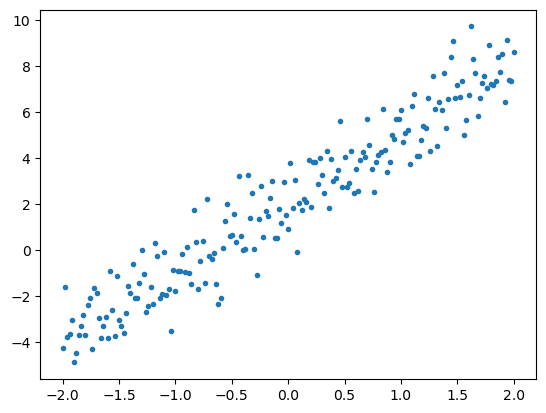

In [16]:
# Plot all the data
plt.plot(x, y, '.')
plt.show()

In [17]:
class MyModel(tf.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Initialize the weights to `5.0` and the bias to `0.0`
       # In practice, these should be randomly initialized
        self.w = tf.Variable(5.0)
        self.b = tf.Variable(0.0)
        
    def __call__(self, x):
        return self.w * x + self.b
    
model = MyModel()

print('Variables', model.variables)

# verify that model works 
assert model(3.0).numpy() == 15.0

Variables (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


In [18]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
    return tf.reduce_mean(tf.square(target_y - predicted_y))

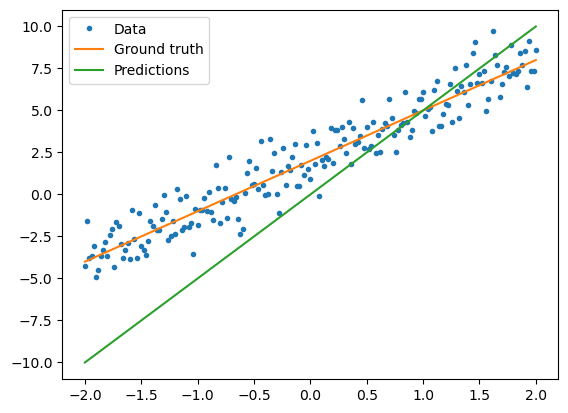

Current loss: 10.742311


In [19]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(y, model(x)).numpy())

In [20]:
# Given a callable model, inputs, outputs, and a learning rate 

def train(model, x, y, learning_rate):
    
    with tf.GradientTape() as tape:
        
        current_loss = loss(y, model(x))
        
    # Use GradientTape to calculate the gradients with respect to W and b   
    dw, db = tape.gradient(current_loss, [model.w, model.b])
    
    # Subtract the gradient scaled by the learning rate
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)
    

In [21]:
model = MyModel()

# Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = range(10)

# Define a training loop
def report(model, loss):
    return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"


def training_loop(model, x, y):

    for epoch in epochs:
        
        # Update the model with the single giant batch
        train(model, x, y, learning_rate=0.1)

        # Track this before I update
        weights.append(model.w.numpy())
        biases.append(model.b.numpy())
        current_loss = loss(y, model(x))

        print(f"Epoch {epoch:2d}:")
        print("    ", report(model, current_loss))

In [22]:
# Do the training
current_loss = loss(y, model(x))

print(f"Starting:")
print("    ", report(model, current_loss))

training_loop(model, x, y)

Starting:
     W = 5.00, b = 0.00, loss=10.74231
Epoch  0:
     W = 4.46, b = 0.41, loss=6.70833
Epoch  1:
     W = 4.07, b = 0.75, loss=4.39048
Epoch  2:
     W = 3.79, b = 1.01, loss=3.04794
Epoch  3:
     W = 3.58, b = 1.22, loss=2.26393
Epoch  4:
     W = 3.42, b = 1.39, loss=1.80233
Epoch  5:
     W = 3.31, b = 1.53, loss=1.52833
Epoch  6:
     W = 3.23, b = 1.64, loss=1.36443
Epoch  7:
     W = 3.17, b = 1.73, loss=1.26563
Epoch  8:
     W = 3.13, b = 1.79, loss=1.20567
Epoch  9:
     W = 3.10, b = 1.85, loss=1.16903


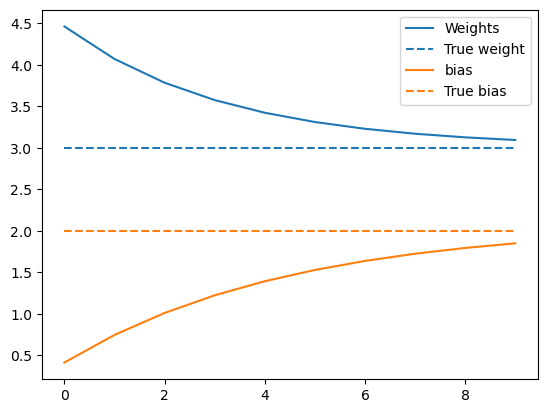

In [23]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(epochs, weights, label='Weights', color=colors[0])
plt.plot(epochs, [TRUE_W] * len(epochs), '--',
         label = "True weight", color=colors[0])

plt.plot(epochs, biases, label='bias', color=colors[1])
plt.plot(epochs, [TRUE_B] * len(epochs), "--",
         label="True bias", color=colors[1])

plt.legend()
plt.show()

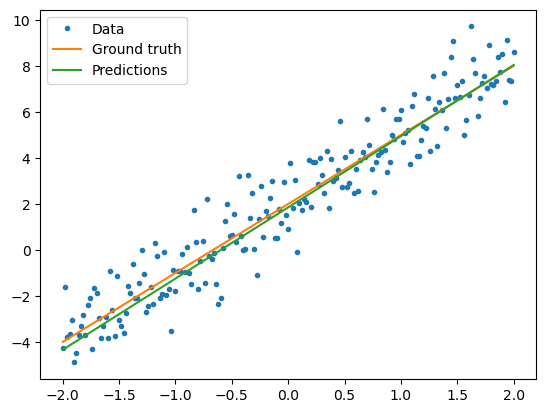

Current loss: 1.169034


In [24]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())